<a href="https://colab.research.google.com/github/SurajTC/WASSA_2023_EMO/blob/main/WASSA_2023_EMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Notebook Setup**

In [1]:
!pip install -q transformers

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics

import transformers
# from transformers import BertTokenizer, BertModel, BertConfig
from transformers import RobertaModel, RobertaTokenizer
# from transformers import AutoTokenizer
# from transformers import AutoModelForSequenceClassification


import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch import cuda

In [3]:
!nvidia-smi

Sat Apr 22 00:50:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


## **Read Data**

In [5]:
df_emo = pd.read_csv("https://raw.githubusercontent.com/SurajTC/WASSA_2023_EMO/main/dataset/WASSA23_essay_level_with_labels_train.tsv", 
                 sep="\t")
df_emo = df_emo[['essay', 'emotion']]

df_emo_dev = pd.read_csv("https://raw.githubusercontent.com/SurajTC/WASSA_2023_EMO/main/dataset/WASSA23_essay_level_dev.tsv", 
                  sep="\t")
df_emo_dev = df_emo_dev[['essay']]

df_emo_gold_dev = pd.read_csv("https://raw.githubusercontent.com/SurajTC/WASSA_2023_EMO/main/dataset/goldstandard_dev.tsv",
                              sep="\t", header=None)
df_emo_gold_dev = df_emo_gold_dev[[2]]
df_emo_gold_dev.rename({2: 'emotion_true'}, axis=1, inplace=True)

df_emo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 792 entries, 0 to 791
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   essay    792 non-null    object
 1   emotion  792 non-null    object
dtypes: object(2)
memory usage: 12.5+ KB


In [6]:
df_emo.head()

,essay,emotion
0,It breaks my heart to see people living in tho...,Hope/Sadness
1,I wonder why there aren't more people trying t...,Anger
2,"After reading the article, you can't help but ...",Sadness
3,It is so sad that someone who had such an amaz...,Sadness
4,"From reading the article, it looks like the wo...",Neutral


In [7]:
df_emo.emotion.value_counts()

Sadness                  297
Neutral                  202
Anger                     67
Disgust                   44
Anger/Disgust             28
Disgust/Sadness           18
Neutral/Sadness           18
Fear/Sadness              16
Hope/Sadness              15
Anger/Sadness             14
Fear                      10
Hope                      10
Surprise                   9
Anger/Neutral              8
Joy                        5
Hope/Neutral               4
Disgust/Surprise           4
Disgust/Neutral            3
Anger/Surprise             3
Joy/Sadness                3
Fear/Hope                  2
Fear/Neutral               2
Disgust/Fear               2
Neutral/Surprise           2
Anger/Disgust/Sadness      1
Anger/Joy                  1
Joy/Neutral                1
Anger/Fear                 1
Sadness/Surprise           1
Anger/Hope                 1
Name: emotion, dtype: int64

In [8]:
target_labels = [i for i in df_emo.emotion.unique() if not len(i.split('/')) -1]
target_labels = sorted(target_labels)
print(target_labels)

['Anger', 'Disgust', 'Fear', 'Hope', 'Joy', 'Neutral', 'Sadness', 'Surprise']


In [9]:
def encode_label(combined):
  assert len(target_labels)
  encoded = [0] * len(target_labels)
  for label in combined.split('/'):
    encoded[target_labels.index(label)] = 1
  return encoded

df = df_emo.copy()
df.emotion = df.emotion.apply(lambda x: encode_label(x))
df[target_labels] = pd.DataFrame(df.emotion.to_list(), index=df.index)
df = df.drop(columns='emotion')
df.head()

,essay,Anger,Disgust,Fear,Hope,Joy,Neutral,Sadness,Surprise
0,It breaks my heart to see people living in tho...,0,0,0,1,0,0,1,0
1,I wonder why there aren't more people trying t...,1,0,0,0,0,0,0,0
2,"After reading the article, you can't help but ...",0,0,0,0,0,0,1,0
3,It is so sad that someone who had such an amaz...,0,0,0,0,0,0,1,0
4,"From reading the article, it looks like the wo...",0,0,0,0,0,1,0,0


## **Preprocess the Data**


In [10]:
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VAL_BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 1e-05

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [11]:
# TOKENIZER_MODEL= "cardiffnlp/twitter-roberta-base-sentiment"
# tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_MODEL)

In [12]:
class prepare_data(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.essay = dataframe.essay
        self.targets = self.data[target_labels].values
        self.max_len = max_len

    def __len__(self):
        return len(self.essay)

    def __getitem__(self, index):
        essay = str(self.essay[index])
        essay = " ".join(essay.split())

        inputs = self.tokenizer.encode_plus(
            essay,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index])
        }

In [13]:
TRAIN_SIZE = 0.95

df_train = df.sample(frac=TRAIN_SIZE, random_state=42)
df_val = df.drop(df_train.index).reset_index(drop=True)
df_train = df_train.reset_index(drop=True)

print("No of Samples : {}".format(df.shape))
print("Train         : {}".format(df_train.shape))
print("Validation    : {}".format(df_val.shape))

train_data = prepare_data(df_train, tokenizer, MAX_LEN)
val_data = prepare_data(df_val, tokenizer, MAX_LEN)

No of Samples : (792, 9)
Train         : (752, 9)
Validation    : (40, 9)


In [14]:
train_data_loader = DataLoader(
    train_data,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
    )

val_data_loader = DataLoader(
    train_data,
    batch_size=VAL_BATCH_SIZE,
    shuffle=False,
    num_workers=0
    )

## **Train Network**

In [15]:
class network(torch.nn.Module):
    def __init__(self):
        super(network, self).__init__()
        # self.base = transformers.BertModel.from_pretrained('bert-base-uncased',  return_dict=False)
        # self.base = AutoModelForSequenceClassification.from_pretrained(TOKENIZER_MODEL)
        self.base = RobertaModel.from_pretrained('roberta-base', return_dict=False)
        # self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, len(target_labels))
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, output = self.base(
        # output = self.base(
            input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids
            )
        output_dropout = self.dropout(output)
        output = self.linear(output_dropout)
        return output

# del model
model = network()
model = model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [17]:
val_targets=[]
val_outputs=[]

In [18]:
def train(
    epochs, 
    train_loader, 
    val_loader, 
    model, 
    optimizer, 
    checkpoint_path, 
    best_model_path):
  valid_loss_min = np.Inf

  for epoch in range(1, epochs+1):
    train_loss = 0
    valid_loss = 0

    model.train()
    print('############# Epoch {}: Training Start   #############'.format(epoch))
    for batch_idx, data in enumerate(train_loader):

        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        #if batch_idx%5000==0:
         #   print(f'Epoch: {epoch}, Training Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))

    print('############# Epoch {}: Training End     #############'.format(epoch))
    
    print('############# Epoch {}: Validation Start   #############'.format(epoch))
   
    ######################    
    # validate the model #
    ######################
 
    model.eval()
   
    with torch.no_grad():
      for batch_idx, data in enumerate(val_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            val_targets.extend(targets.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

      print('############# Epoch {}: Validation End     #############'.format(epoch))

      train_loss = train_loss/len(train_loader)
      valid_loss = valid_loss/len(val_loader)

      print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

      checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
      }
        
      # save_ckp(checkpoint, False, checkpoint_path, best_model_path)
        
      ## TODO: save the model if validation loss has decreased
      if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).'.format(valid_loss_min,valid_loss))

        # save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = valid_loss

    print('############# Epoch {}  Done   #############\n'.format(epoch))

  return model

In [19]:
ckpt_path = "/checkpoints/"
best_model_path = "/best_model.pt"

In [20]:
trained_model = train(EPOCHS, train_data_loader, val_data_loader, model, optimizer, ckpt_path, best_model_path)

############# Epoch 1: Training Start   #############
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.023836 	Average Validation Loss: 0.016586
Validation loss decreased (inf --> 0.016586).
############# Epoch 1  Done   #############

############# Epoch 2: Training Start   #############
############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.015662 	Average Validation Loss: 0.014129
Validation loss decreased (0.016586 --> 0.014129).
############# Epoch 2  Done   #############

############# Epoch 3: Training Start   #############
############# Epoch 3: Training End     #############
############# Epoch 3: Validation Start   #############
############# Epoch 3: Validation End     ###########

In [21]:
output_model_file = 'pytorch_roberta_sentiment.bin'
output_vocab_file = './'

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('All files saved')
print('This tutorial is completed')

All files saved
This tutorial is completed


## **Validation**

In [22]:
df_val.head()

,essay,Anger,Disgust,Fear,Hope,Joy,Neutral,Sadness,Surprise
0,PTSD is a tough problem to have I feel bad for...,0,0,0,0,0,0,1,0
1,The sights and sounds of war are horrible and ...,0,0,0,0,1,0,0,0
2,This poor child I just feel so bad. You would ...,0,0,0,0,0,0,1,0
3,A zoo named world zoo was the home to many suf...,0,0,0,0,0,0,1,0
4,It is really hard to read stories about natura...,0,1,0,0,0,0,0,0


In [32]:
predictions = []

for sample in df_emo_dev.essay.values:
  encodings = tokenizer.encode_plus(
    sample,
    None,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    return_token_type_ids=True,
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt')
  model.eval()

  with torch.no_grad():
    input_ids = encodings['input_ids'].to(device, dtype=torch.long)
    attention_mask = encodings['attention_mask'].to(device, dtype=torch.long)
    token_type_ids = encodings['token_type_ids'].to(device, dtype=torch.long)
    output = model(input_ids, attention_mask, token_type_ids)
    final_output = torch.sigmoid(output).cpu().detach().numpy().tolist()
    label = target_labels[int(np.argmax(final_output, axis=1))]
    # index, max = np.arg_max(final_output), final_output[0][np.arg_max]

    # print(final_output, final_output[[np.argmax(final_output)]])
    # label = []

    predictions.append({
        'emotion': label,
        'output': final_output[0]
    })

In [71]:
multi_index = [i for i, l in enumerate(df_emo_gold_dev.emotion_true) if len(l.split('/')) > 1]
len(multi_index)

38

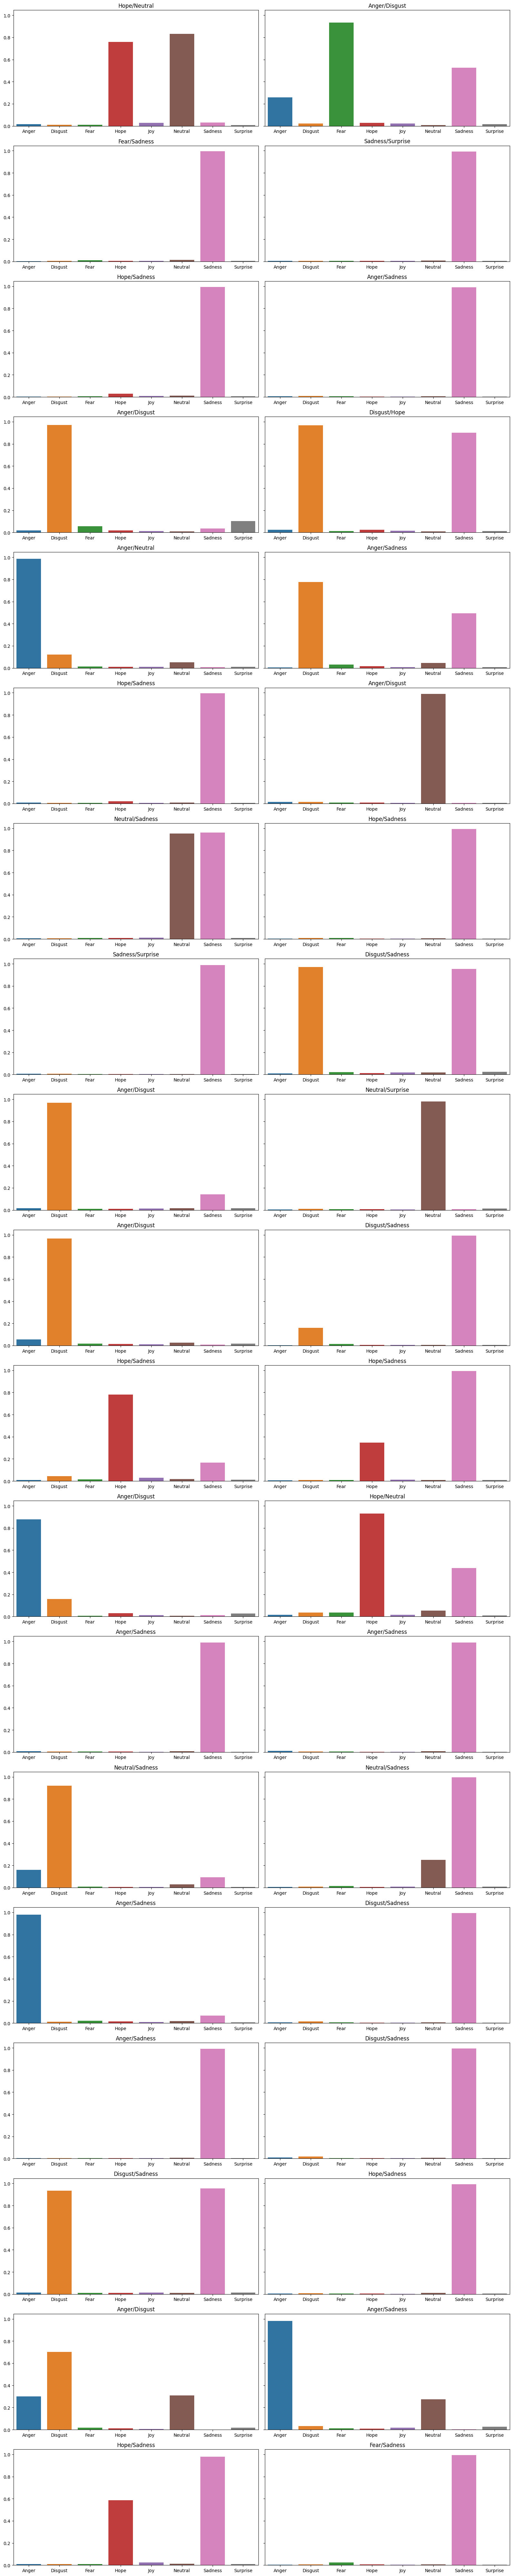

In [76]:
fig, axes = plt.subplots(19, 2, sharex=False, sharey=True, figsize=(16,80))

for i in range(19):
  for j in range(2):
    sns.barplot(ax=axes[i, j], x=target_labels, y=predictions[multi_index[j*19+i]]['output'])
    axes[i, j].set_title(df_emo_gold_dev.emotion_true[multi_index[j*19+i]])
plt.tight_layout()

In [85]:
df_dev_pred = pd.DataFrame(predictions, columns=['emotion'])
df_dev_pred.emotion.value_counts()

Sadness     97
Neutral     56
Disgust     26
Anger       14
Fear         7
Hope         6
Joy          1
Surprise     1
Name: emotion, dtype: int64

In [36]:
df_emo_gold_dev.emotion_true.value_counts()

Sadness             75
Neutral             47
Anger               23
Disgust             11
Anger/Sadness        7
Hope/Sadness         7
Anger/Disgust        7
Hope                 6
Fear                 6
Disgust/Sadness      5
Neutral/Sadness      3
Sadness/Surprise     2
Fear/Sadness         2
Joy                  2
Hope/Neutral         2
Anger/Neutral        1
Disgust/Hope         1
Neutral/Surprise     1
Name: emotion_true, dtype: int64

In [87]:
predictions[89]

{'emotion': 'Surprise',
 'output': [0.21707527339458466,
  0.02697879821062088,
  0.013270552270114422,
  0.016507796943187714,
  0.029810775071382523,
  0.060843031853437424,
  0.007159716449677944,
  0.7017282247543335]}

In [86]:
df_dev_pred[df_dev_pred.emotion.isin(['Surprise'])]

,emotion
89,Surprise


In [37]:
df_dev_true = df_emo_gold_dev.copy()
df_dev_true.emotion_true = df_dev_true.emotion_true.apply(lambda x: encode_label(x))
df_dev_true[target_labels] = pd.DataFrame(df_dev_true.emotion_true.to_list(), index=df_dev_true.index)
df_dev_true = df_dev_true.drop(columns='emotion_true')

df_dev_pred.emotion = df_dev_pred.emotion.apply(lambda x: encode_label(x))
df_dev_pred[target_labels] = pd.DataFrame(df_dev_pred.emotion.to_list(), index=df_dev_pred.index)
df_dev_pred = df_dev_pred.drop(columns='emotion')

dev_pred, dev_true = df_dev_pred[target_labels].values, df_dev_true[target_labels].values

accuracy = metrics.accuracy_score(dev_true, dev_pred)
f1_score_micro = metrics.f1_score(dev_true, dev_pred, average='micro')
f1_score_macro = metrics.f1_score(dev_true, dev_pred, average='macro')

print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.5913461538461539
F1 Score (Micro) = 0.6916299559471366
F1 Score (Macro) = 0.42625874125874125


## **Prepare Submission**

In [29]:
filename = "predictions_EMO.tsv"

df_submission = pd.DataFrame(predictions, columns=['emotion'])
df_submission.to_csv(filename, sep="\t", header=False, index=False)

In [30]:
df_submission.emotion.value_counts()

Sadness     97
Neutral     56
Disgust     26
Anger       14
Fear         7
Hope         6
Joy          1
Surprise     1
Name: emotion, dtype: int64

In [31]:
!cd /content
!rm -rf './predictions.zip'
!zip -r './predictions.zip' './predictions_EMO.tsv'

  adding: predictions_EMO.tsv (deflated 88%)
